- Given a lat lon
- Assume maximum temperature
- convert lat lon to correct projection
- join all times together
- from megacube extract that geospatial point
    - investgate interopolation vs. find nearest
- collapse time by mean
- return float

In [199]:
REQUEST = '''{
    "args": {
        "date": ["2013-02-27"],
        "start_date": ["2012-01-01"],
        "end_date": ["2012-01-03"],
        "lat": ["51"],
        "lon": ["-1"]
    },
    "path": {
        "parameter": "temperature",
        "operation": "min"
    }
}'''


In [200]:
# GET /helloworld

print('hello world')


hello world


In [202]:
import datetime
import iris

iris.FUTURE.netcdf_promote = True

def load_data(data_path, dates):
    # pattern is glob style
#     cubes = iris.load('/opt/data/{}'.format(pattern))
    filenames = get_filenames(data_path, dates)
    cubes = iris.load(filenames)
    return iris.cube.CubeList(cubes).concatenate_cube()


In [203]:
import cartopy

def transform_coords(cube, lon, lat):
    expected_proj = cube.coords('projection_y_coordinate')[0].coord_system.as_cartopy_crs()
    given_proj = cartopy.crs.PlateCarree()
    return expected_proj.transform_point(lon, lat, given_proj)

In [204]:

def get_coords(cube, lat, lon):
    x, y = transform_coords(cube, lon, lat)
    first_year = next(cube.slices_over('time'))
    samples = [('projection_y_coordinate', y), ('projection_x_coordinate', x)]
    first_point = first_year.interpolate(samples, iris.analysis.Nearest())
    exact_x = first_point.coord('projection_x_coordinate')[0].points[0]
    exact_y = first_point.coord('projection_y_coordinate')[0].points[0]
    
    return(exact_x, exact_y)
    


In [205]:

def collapse_latlon(cube, x, y):
    x_const = iris.Constraint(projection_x_coordinate=x)
    y_const = iris.Constraint(projection_y_coordinate=y)
    return cube.extract(x_const).extract(y_const)

In [206]:
from datetime import timedelta

def expand_years(start, end, past_years=40):
    years = [
        datetime.datetime(
            d.year - i,
            d.month,
            d.day)
        for i in range(past_years)
        for d in select_all_days(start, end)]
    return years

def select_all_days(start, end):
    delta = end - start
    days = [end - timedelta(days=i) for i in range(delta.days)]
    return days

def extract_dates(cube, dates):
    time_units = cube.coord('time').units
    vals = [time_units.date2num(date + timedelta(hours=12)) for date in dates] #12pm, not midnight
    time_constraint = iris.Constraint(time=vals)
    return cube.extract(time_constraint)

In [207]:
def mean(cube):
    return cube.collapsed('time', iris.analysis.MEAN)

def cmax(cube):
    return cube.collapsed('time', iris.analysis.MAX)

def cmin(cube):
    return cube.collapsed('time', iris.analysis.MIN)

In [208]:
patterns = {
    'temperature': 'maximum-temperature',
    'rainfall': 'rainfall'
}

operations = {
    'mean': mean,
    'max': cmax,
    'min': cmin
}

In [100]:
import glob
def get_filenames(data_path, dates):
    years = set([date.year for date in dates])
    filenames = [f for y in years for f in glob.glob('/opt/data/{}/*_{}*.nc'.format(data_path, y))]
    return filenames

In [81]:
from collections import defaultdict
CACHED_POINTS = defaultdict(lambda: None)

In [210]:
import io
import boto3
import uuid
import matplotlib.pyplot as plt


def upload_image(byte_data):
    bucket_name = 'microsoft-hack'
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    uid = str(uuid.uuid4())
    bucket.put_object(
        Body=byte_data,
        ContentType='image/png',
        Key='{}.png'.format(uid),
        ACL='public-read')
    
    return 'https://s3-eu-west-1.amazonaws.com/{}/{}.png'.format(bucket_name, uid)

def graph(cube, times):
    plt.plot(times, cube.data, ':o')
    plt.xticks(rotation=45)
    plt.xlabel('Year');
    plt.ylabel('Temp/C');
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    s3_url = upload_image(img_data)
    return s3_url

def get_response(cube, dates, x, y, operation):
    time_cube = collapse_latlon(cube, x, y)
    collapsed_time_cube = extract_dates(time_cube, dates)
    
    s3_url = graph(collapsed_time_cube, dates)

    collapsed_cube = operation(collapsed_time_cube)
    
    val = float(collapsed_cube.data)
    
    response = {
        'value': val,
        'start_date': dates[-1].strftime('%Y-%m-%d'),
        'end_date': dates[0].strftime('%Y-%m-%d'),
        'graph': s3_url
    }
    
    return response

In [211]:
def parse_query(req):
    query = req['args']
    lat = float(query['lat'][0])
    lon = float(query['lon'][0])
    start, end = parse_date_range(query)
    return lat, lon, start, end

def parse_path(req):
    path = req['path']
    param = path['parameter']
    op = path['operation']
    return param, op

def parse_date_range(query):
    if 'start_date' and 'end_date' in query.keys():
        start_date = datetime.datetime.strptime(query['start_date'][0], '%Y-%m-%d')
        end_date = datetime.datetime.strptime(query['end_date'][0], '%Y-%m-%d')
    elif 'date' in query.keys():
        start_date = datetime.datetime.strptime(query['date'][0], '%Y-%m-%d')
        end_date = start_date + datetime.timedelta(days=1)
    else:
        start_date = datetime.datetime.now()
        end_date = start_date + datetime.timedelta(days=1)
    return start_date, end_date

In [212]:
def handle_request(req, mode, dates_func):
    param, op = parse_path(req)
    lat, lon, start, end = parse_query(req)

    data_path = patterns[param]
    operation = operations[op]

    dates = dates_func(start, end)
    cube = load_data(data_path, dates)
    x, y = get_coords(cube, lat, lon)
    
    cache_key = (mode, param, x, y, start, end, operation)
    
    if CACHED_POINTS[cache_key] != None:
        response = CACHED_POINTS[cache_key]
    else:
        response = get_response(cube, dates, x, y, operation)
        CACHED_POINTS[cache_key] = response
    return response

{"graph": "https://s3-eu-west-1.amazonaws.com/microsoft-hack/0aa46020-6444-4a4a-abd9-8597731df315.png", "end_date": "2012-01-03", "value": -1.4389586448669434, "start_date": "1973-01-02"}


/Users/alex/anaconda3/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


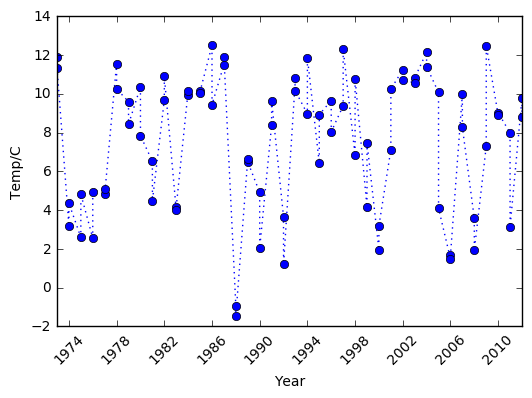

In [213]:
# GET /:parameter/:operation/climatology
import json

req = json.loads(REQUEST)
response = handle_request(req, 'climatology', expand_years)
print(json.dumps(response))

{"graph": "https://s3-eu-west-1.amazonaws.com/microsoft-hack/49a21782-fd15-46fd-8b27-72385d810a21.png", "end_date": "2012-01-03", "value": 11.354076385498047, "start_date": "2012-01-02"}


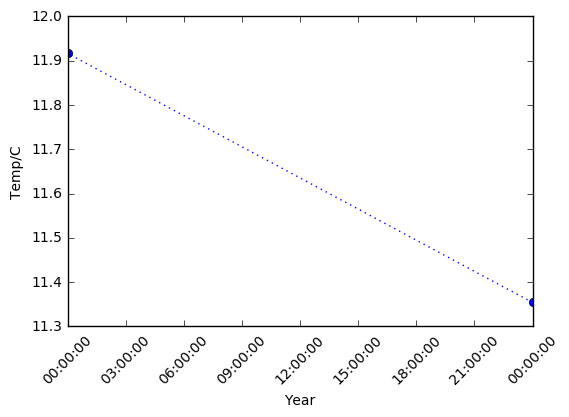

In [214]:
# GET /:parameter/:operation/range
import json

req = json.loads(REQUEST)
response = handle_request(req, 'range', select_all_days)
print(json.dumps(response))

In [197]:
# ResponseInfo GET /:parameter/mean/range
print(json.dumps({
    "headers" : {
        "Content-Type" : "application/json"
    }
}))

{"headers": {"Content-Type": "application/json"}}


In [198]:
# ResponseInfo GET /:parameter/mean/climatology
print(json.dumps({
    "headers" : {
        "Content-Type" : "application/json"
    }
}))

{"headers": {"Content-Type": "application/json"}}


In [50]:
!ls /opt/data

Untitled.ipynb      maximum-temperature
